# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Basic libraries
# 
import pandas as pd
import numpy as np
import datetime as dt


# Visualization libraries
#
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go


# Scipy library
#
from scipy import stats


# Sklearn library
#
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


# Feature engine library
#
import feature_engine
from   feature_engine.outliers import Winsorizer

# Import data

In [3]:
# Load Dataset
#
df = pd.read_csv('Data/OnlineRetail.csv', encoding="ISO-8859-1")

print('[INFO] Number of instances: ', df.shape[0])
print('[INFO] Number of features:  ', df.shape[1])

# Visualize DataFrame
#
df.head( 3 )

[INFO] Number of instances:  541909
[INFO] Number of features:   8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/10 8:26,2.75,17850.0,United Kingdom


## Data Pre-processing

**Observations/Findings:**

- The min and max value for Quantity is 80995, this could represent cancelled or returned orders.
- The UnitPrice also have few negative values which is uncommon,these transactions could represent cancelled orders by customers or bad-debt incurred by the business.
- Bad debt adjustments will be dropped from the dataset as these do not represent actual sales. 

We need to clean the above values by removing from the dataset


- There are almost 25% missing CustomerID. We need to remove them as there is no way we can get the number of CustomerID
- As customer clusters may vary by geography, we will restrict the data to only United Kingdom customers, which contains most of our customers historical data (~90%).

In [4]:
# More than 90% of customers are 'United Kingdom' customers.
#
df = df[df.Country == 'United Kingdom']

In [5]:
# Removing the negative values from UnitPrice and Quantity
#
df = df[df[ 'Quantity'  ] > 0]
df = df[df[ 'UnitPrice' ] > 0]

# Removing the Null values from the data.
#
df = df[ pd.notnull(df['CustomerID']) ]

In [6]:
# Replace 'InvoiceDate' to 'Date'
#
df = df.rename(columns = {'InvoiceDate': 'Date'})

# Convert 'Date' to datetime64
#
df[ 'Date' ] = df[ 'Date' ].astype( 'datetime64' )


In [7]:
# Convert 'CustomerID' to int
#
df[ 'CustomerID' ] = df[ 'CustomerID' ].astype( 'int' )

**Note:** We have all the crucial information we need

- Customer ID
- Unit Price
- Quantity
- Invoice Date

### Calculate Revenue

In [8]:
# Revenue = Order Count * Average Revenue per Order
#
df['Revenue'] = df['Quantity'] * df['UnitPrice']

## Aggregating the Orders by Month

In [9]:
df_agg = df.resample('M', on = 'Date').sum()

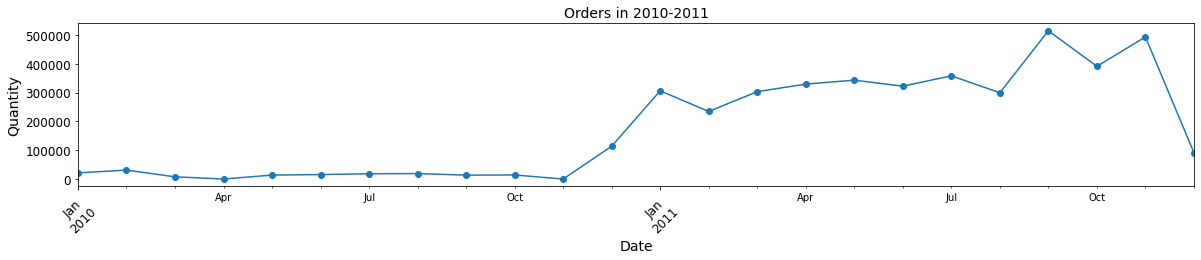

In [10]:
df_agg[ 'Quantity' ].plot(color='tab:Blue', marker='o', figsize = (20, 3))


plt.title('Orders in 2010-2011', size = 14)
#
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12)
#
plt.xlabel('Date', size = 14)
plt.ylabel('Quantity', size = 14);
#
plt.legend([], frameon = False)


# RFM Analysis

**Recency-Frequency-Monetary**
    
    
RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.

* Recency — how long it’s been since a customer bought something from us
* Frequency — how often a customer buys from us
* Monetary value — the total value of purchases a customer has made

### Keep useful feature for RFM analysis

- CustomerID
- Date
- InvoiceNo
- Revenue

In [11]:
df = df[ ['CustomerID' , 'Date', 'InvoiceNo', 'Revenue'] ]

## Recency

In [12]:
# The last invoice date is 2011–12–09, we will use this date to calculate Recency
NOW = dt.date(2011, 12, 9) 

df['Date'] = pd.DatetimeIndex(df[ 'Date' ]).date

In [13]:
# Create Recency DataFrame
# 
df_Recency         = df.groupby(['CustomerID'], as_index=False)['Date'].max()
df_Recency.columns = ['CustomerID','Last_Purchase_Date']

df_Recency['Recency']   = df_Recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_Recency.drop(columns = ['Last_Purchase_Date'], inplace=True)


# Recency DataFrame visualization
#
df_Recency.head( 5 )

,CustomerID,Recency
0,12346,325
1,12747,22
2,12748,4
3,12749,22
4,12820,44


## Frequency

In [14]:
# Create Frequeny DataFrame
#
df_Frequency = df.groupby('CustomerID').agg( {'InvoiceNo' : lambda x: len(x) })
df_Frequency.rename(columns = {'InvoiceNo' : 'Frequency'}, inplace = True)

# Frequeny DataFrame visualization
#
df_Frequency.head( 5 )

,Frequency
CustomerID,
12346,1
12747,103
12748,4595
12749,199
12820,59


## Monetarty

In [15]:
# Create Monetarty DataFrame
#
df_Monetarty = df.groupby('CustomerID').agg( {'Revenue' : lambda x: x.mean()} )
df_Monetarty.rename(columns = {'Revenue' : 'Monetary'}, inplace = True)

# Monetarty DataFrame visualization
#
df_Monetarty.head( 5 )

,Monetary
CustomerID,
12346,77183.600000
12747,40.737961
12748,7.338353
12749,20.557186
12820,15.971864


In [16]:
# Frequency - Monetarty could be calculated together using the following code
# ---------------------------------------------------------------------------
#
#
# # df_Frequency_Monetarty = df.groupby('CustomerID').agg({'InvoiceNo'  : lambda x:len(x),
#                                                        'Revenue'    : lambda x:x.sum()})

# df_Frequency_Monetarty.rename(columns = {'InvoiceNo' : 'Frequency',
#                                          'Revenue'   : 'Monetary'},inplace= True)
# df_Frequency_Monetarty.head( 5 )

In [17]:
# Merge Recency, Frequency & Monetary DataFrames
#
RFM = df_Recency.merge(df_Frequency, left_on='CustomerID', right_on='CustomerID')
#
RFM = RFM.merge(df_Monetarty, left_on='CustomerID', right_on='CustomerID')


# RFM DataFrame visualization
#
RFM.head( 5 )

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.600000
1,12747,22,103,40.737961
2,12748,4,4595,7.338353
3,12749,22,199,20.557186
4,12820,44,59,15.971864


## Calculate RFM-Scores

**Methodology:** Next, we split the metrics into segments using quantiles. 

We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [18]:
quantiles = RFM.quantile(q = [0.25, 0.50, 0.75])

quantiles = quantiles.to_dict()

In [19]:
def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

### Calculate R_score, F_score, M_score

In [20]:
# Calculate R_score, F_score, M_score
# 
RFM['R_score'] = RFM['Recency'].apply(RScore,    args = ('Recency',   quantiles))
RFM['F_score'] = RFM['Frequency'].apply(FMScore, args = ('Frequency', quantiles))
RFM['M_score'] = RFM['Monetary'].apply(FMScore,  args = ('Monetary',  quantiles))

### Calculating the RFM_Segment & RFM-score

RFM_Segment = str(R_score) + str(F_score) + str(M_score)
RFM_Score   = R_score + F_score + M_score

In [21]:
# Calculate RFM_Segment
# 
RFM['RFM_Segment'] = RFM.R_score.map(str) + RFM.F_score.map(str) + RFM.M_score.map(str)

# Calculate RFM_Score
#
RFM[ 'RFM_Score' ] = RFM[ 'R_score' ] + RFM[ 'F_score' ] + RFM[ 'M_score' ]

# Sort DataFrame based on RFM-Score
#
RFM.sort_values(by = 'RFM_Score', inplace = True)

In [22]:
# Remove some outliers, namely
# Extreme Monetary, with only one sales and R_score > 1
#
RFM = RFM[ ~( (RFM['Monetary'] > np.quantile(RFM['Monetary'], 0.95)) & (RFM['Frequency'] == 1) & (RFM['R_score'] > 1) ) ]
#
# This could be removed, depending on the selected strategy.

### Visualization 

- DataFrame visualization
- RFM-Segment & RFM-Score bar-plots
- Average Revenue Per User

In [23]:
# RFM DataFrame visualization
#
RFM.head( 5 )

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
3272,17389,8,213,149.453897,1,1,1,111,3
1904,15498,4,512,26.008594,1,1,1,111,3
2742,16652,-1,118,57.406525,1,1,1,111,3
457,13458,5,382,25.252801,1,1,1,111,3
184,13078,-1,358,35.273575,1,1,1,111,3


#### RFM-Segment & RFM-Score bar-plots

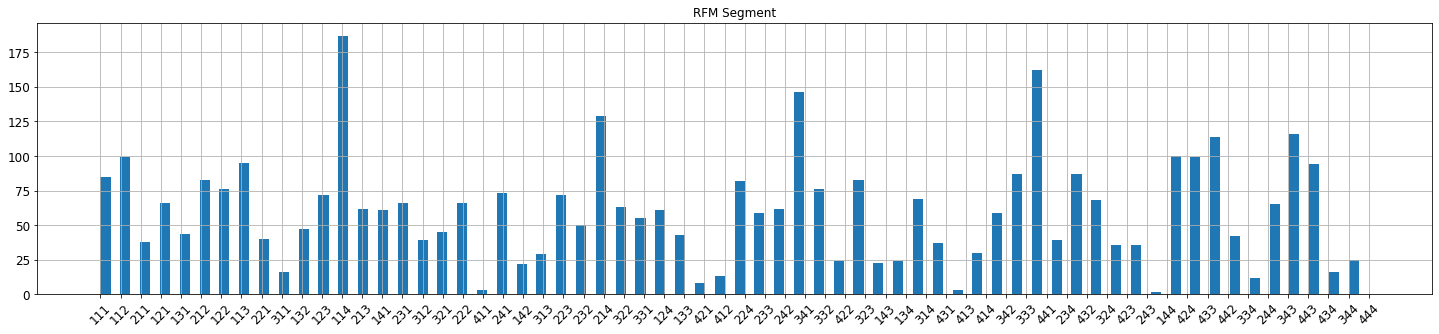

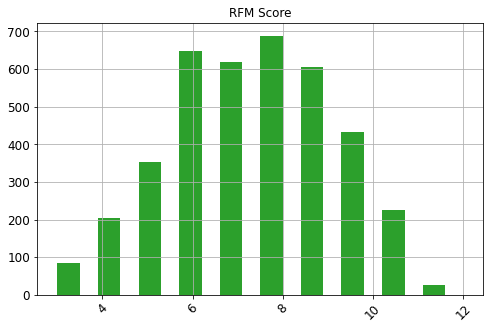

In [24]:
RFM['RFM_Segment'].hist( figsize = (25, 5), bins = RFM.RFM_Segment.nunique(), width = 0.5, color = 'tab:blue')
plt.title('RFM Segment')
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12);
plt.show()

RFM['RFM_Score'].hist( figsize = (8, 5), bins = RFM.RFM_Score.nunique(), width = 0.5, color = 'tab:green')
plt.title('RFM Score')
plt.xticks(rotation = 45, size = 12);
plt.yticks(size = 12);
plt.show()


#### Average Revenue Per User

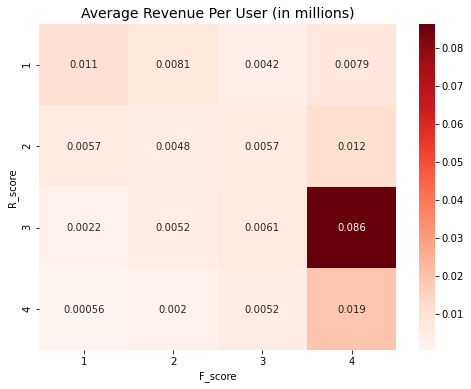

In [25]:
A = RFM.groupby(['R_score', 'F_score']).sum()[['Monetary']].reset_index().pivot('R_score', 'F_score', 'Monetary')


plt.figure( figsize = (8, 6) );
#
sns.heatmap( A / 1.e+6, annot = True, cmap = 'Reds');
plt.title('Average Revenue Per User (in millions)', size = 14);

## Customer characterization

After some calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

- **Champions:** Bought recently, buy often and spend the most.
- **Loyal customers:** Buy on a regular basis. Responsive to promotions.
- **Potential loyalist:** Recent customers with average frequency.
- **Recent customers:** Bought most recently, but not often.
- **Promising:** Recent shoppers, but haven’t spent much.
- **Needs attention:** Above average recency, frequency and monetary values. May not have bought very recently though.
- **About to sleep:** Below average recency and frequency. Will lose them if not reactivated.
- **At risk:** Some time since they’ve purchased. Need to bring them back!
- **Can’t lose them:** Used to purchase frequently but haven’t returned for a long time.
- **Hibernating:** Last purchase was long back and low number of orders. May be lost.

In [26]:
print("Best Customers: ",       len(RFM[RFM['RFM_Segment'] == '111']))
print('Loyal Customers: ',      len(RFM[RFM['F_score'] == 1]))
print("Big Spenders: ",         len(RFM[RFM['M_score'] == 1]))
print('Almost Lost: ',          len(RFM[RFM['RFM_Segment'] == '134']))
print('Lost Customers: ',       len(RFM[RFM['RFM_Segment'] == '344']))
print('Lost Cheap Customers: ', len(RFM[RFM['RFM_Segment'] == '444']))

Best Customers:  85
Loyal Customers:  980
Big Spenders:  945
Almost Lost:  24
Lost Customers:  16
Lost Cheap Customers:  25


In [27]:
# # Create human friendly RFM labels
# segt_map = {
#     r'[1-2][1-2]': 'Hibernating',
#     r'[1-2][2-3]': 'At risk',
#     r'[1-2]4': 'Can\'t loose them',
#     r'2[1-2]': 'About to sleep',
#     r'22': 'Need attention',
#     r'[2-3][3-4]': 'Loyal customers',
#     r'31': 'Promising',
#     r'41': 'New customers',
#     r'[3-4][1-2]': 'Potential loyalists',
#     r'4[3-4]': 'Champions'
# }

# segmented_rfm['Segment'] = segmented_rfm['R_score'].map(str) + segmented_rfm['F_score'].map(str)
# segmented_rfm['Segment'] = segmented_rfm['Segment'].replace(segt_map, regex=True)

# segmented_rfm['Segment'].hist( figsize = (15, 6), bins = segmented_rfm['Segment'].nunique())
# plt.xticks( size = 14, rotation = 45)

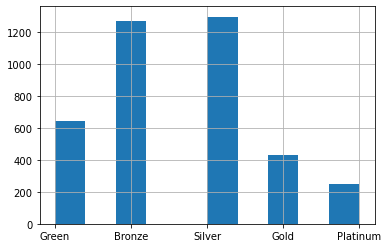

In [28]:
# Create some human friendly labels for the scores
#
RFM[ 'Score' ] = 'Green'
RFM.loc[ RFM['RFM_Score'] >  5, 'Score' ] = 'Bronze' 
RFM.loc[ RFM['RFM_Score'] >  7, 'Score' ] = 'Silver' 
RFM.loc[ RFM['RFM_Score'] >  9, 'Score' ] = 'Gold' 
RFM.loc[ RFM['RFM_Score'] > 10, 'Score' ] = 'Platinum'

# DataFrame visualization
#
RFM[ 'Score' ].hist( );

## K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation. 

### Skewness check

Plotting distribution charts to check for skewness

In [29]:
def check_skew(df_skew, feature):    
    '''
    Function for checking for skewness
    '''
    # Calculate skewness
    skew     = stats.skew( df_skew[ feature ] )
    skewtest = stats.skewtest( df_skew[ feature ] )

    print("{}'s: Skew: {}, : {}".format(feature, skew, skewtest))

    # Distribution plot
    #
    plt.figure(  figsize = (10, 3) )
    sns.distplot(df_skew[ feature ])
    #
    plt.title('Distribution of ' + feature)
    plt.show();

Recency's: Skew: 1.9362216003742183, : SkewtestResult(statistic=33.31326445253411, pvalue=2.481187532480103e-243)


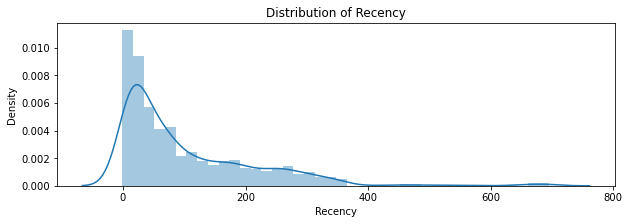

Frequency's: Skew: 18.610074981390653, : SkewtestResult(statistic=79.6902620442163, pvalue=0.0)


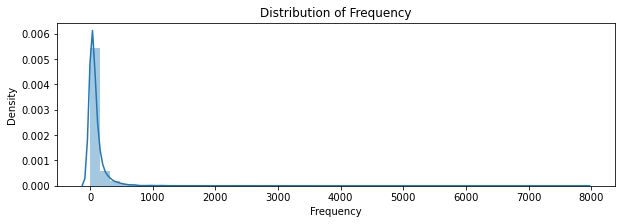

Monetary's: Skew: 57.21061723106678, : SkewtestResult(statistic=103.1265887130838, pvalue=0.0)


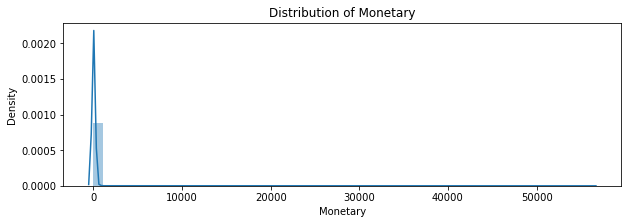

In [30]:
# Plot all Distrubution graphs of Recency, Frequency & Monetary

check_skew(RFM, 'Recency');

check_skew(RFM, 'Frequency');

check_skew(RFM, 'Monetary');

#### Data transformation

The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.

Recency's: Skew: -0.6322509436876709, : SkewtestResult(statistic=-14.838001663855117, pvalue=8.319760537280474e-50)


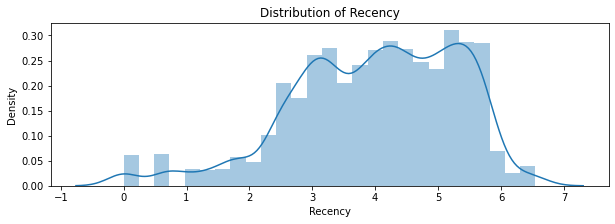

Frequency's: Skew: 0.14945285771185338, : SkewtestResult(statistic=3.7894451635810174, pvalue=0.0001509841351200148)


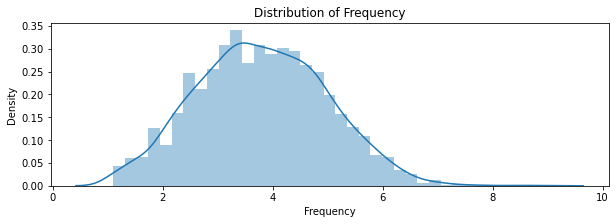

Monetary's: Skew: 1.5414506212826171, : SkewtestResult(statistic=29.014269870274514, pvalue=4.347281212749207e-185)


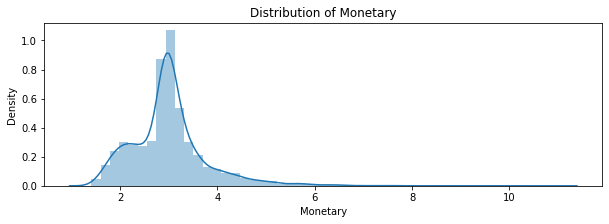

In [31]:
# Make a copy of the DataFrame
# 
RFM_log = RFM[ ['Recency', 'Frequency', 'Monetary']].copy()

# Log features
#
VALUE = max(0, -RFM_log.min().min()) + 1
RFM_log = np.log(RFM_log + VALUE)


# Plot all Distrubution graphs of Recency, Frequency & Monetary
#
check_skew(RFM_log, 'Recency');

check_skew(RFM_log, 'Frequency');

check_skew(RFM_log, 'Monetary');

#### Winsorizing

Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. It is named after the engineer-turned-biostatistician Charles P. Winsor (1895–1951). The effect is the same as clipping in signal processing.

In [32]:
windsoriser = Winsorizer(tail      = 'both', # cap left, right or both tails 
                         fold      = 2,
                         variables = [ 'Recency', 'Frequency', 'Monetary']
                        )

windsoriser.fit( RFM_log )

RFM_log = windsoriser.transform( RFM_log )

### Standarization

Once the skewness is reduced, I standardised the data by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.

In [33]:
# Setup scaler
# 
scaler = StandardScaler()

# Fit scaler
scaler.fit( RFM_log )

RFM_log_scaled = pd.DataFrame(data    = scaler.transform(RFM_log), 
                              columns = RFM_log.columns)

### K-Means clustering process

### Finding the optimal number of clusters

In [34]:
from scipy.spatial.distance import cdist
from sklearn.metrics        import silhouette_score

distortions = [] 
inertias    = [] 
Clusters    = [ [] ]
Centroids   = [ [] ]
K = range(1, 11)
  
for k in K: 
    # Setup K-Means model     
    model = KMeans(n_clusters = k, random_state = 42).fit( RFM_log_scaled ) 
    
    # Fit model
    model.fit( RFM_log_scaled )     

    # Store clusters
    Clusters  += [ model.labels_.tolist() ]
    
    # Get centroids
    Centroids += [ model.cluster_centers_ ]

    # Calculate distortions
    distortions.append( sum(np.min(cdist(RFM_log_scaled, model.cluster_centers_, 'euclidean'),axis=1)) / RFM_log_scaled.shape[0] ) 

    # Calculate inertias
    inertias.append( model.inertia_ ) 
  
    # Calculate Silhouette score
    if (k > 1):
        Sil = silhouette_score(X     = RFM_log_scaled, 
                              labels = model.labels_)

        print('K = %2i Silhouette Score %.3f' % (k, Sil))
    

K =  2 Silhouette Score 0.317
K =  3 Silhouette Score 0.296
K =  4 Silhouette Score 0.292
K =  5 Silhouette Score 0.264
K =  6 Silhouette Score 0.279
K =  7 Silhouette Score 0.292
K =  8 Silhouette Score 0.296
K =  9 Silhouette Score 0.278
K = 10 Silhouette Score 0.280


#### Elbow Method using Distortion and Inertia

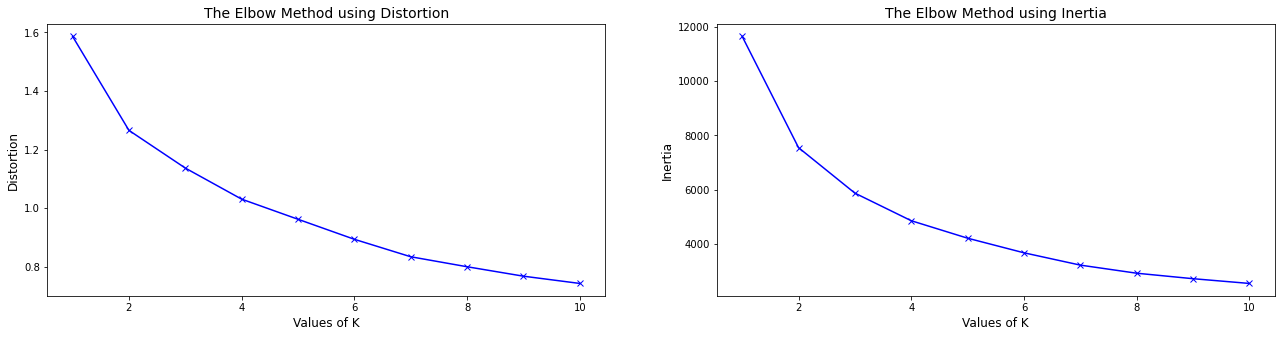

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (22, 5) )
#
ax[0].plot(K, distortions, 'bx-') 
ax[0].set_xlabel('Values of K', size = 12) 
ax[0].set_ylabel('Distortion', size = 12) 
ax[0].set_title('The Elbow Method using Distortion', size = 14) 
#
ax[1].plot(K, inertias, 'bx-') 
ax[1].set_xlabel('Values of K', size = 12) 
ax[1].set_ylabel('Inertia', size = 12) 
ax[1].set_title('The Elbow Method using Inertia', size = 14)

plt.show();


#### Cluster visualization

In [36]:
import umap

UMAP_arg    = { 'n_neighbors': 30, 
                'min_dist':    0.01 }

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Apply UMAP
#
umapModel = umap.UMAP(n_neighbors  = UMAP_arg['n_neighbors'],
                      min_dist     = UMAP_arg['min_dist'],
                      n_components = 2,
                      random_state = 42)

embeddings = umapModel.fit_transform( RFM_log_scaled[ ['Recency', 'Frequency', 'Monetary']].to_numpy() )

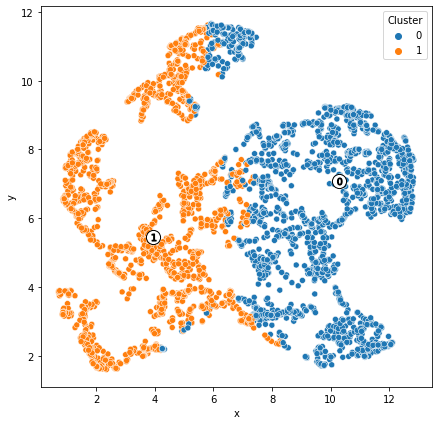

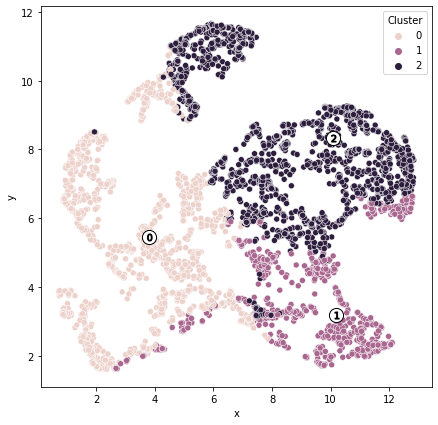

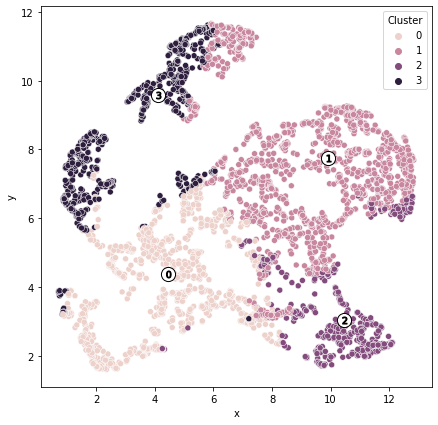

In [37]:
# Create DataFrame
# 
clustering_df = pd.DataFrame( embeddings, columns = ['x', 'y'] )

for k in range(2, 5):
    # Get Cluster    
    clustering_df['Cluster'] = Clusters[k]


    # Clustering visualization in 2D
    #
    plt.figure( figsize = (7, 7) )
    sns.scatterplot(data = clustering_df, x = 'x', y = 'y', hue = 'Cluster')

    # Plot centroids
    #
    centers = umapModel.transform( Centroids[ k ] )
    plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate( centers ):
            plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s = 50, edgecolor='k')

#### Snake plots

In [38]:
def snake_plot(normalised_df, labels, CustomerIDs):

    normalised_df['Cluster']    = labels
    normalised_df['CustomerID'] = CustomerIDs
    

    # Melt data into long format
    df_melt = pd.melt(normalised_df.reset_index(), 
                      id_vars    = ['CustomerID', 'Cluster'],
                      value_vars = ['Recency', 'Frequency', 'Monetary'], 
                      var_name   = 'Metric', 
                      value_name = 'Value')

    plt.figure( figsize = (15, 4) )
    sns.pointplot(data = df_melt, x = 'Metric', y = 'Value', hue = 'Cluster')

    plt.xlabel('Metric', size = 14)
    plt.ylabel('Value',  size = 14)
    plt.xticks(size = 12)
    plt.xticks(size = 12)
    plt.legend(frameon = True, fontsize = 12)
    plt.show()
    

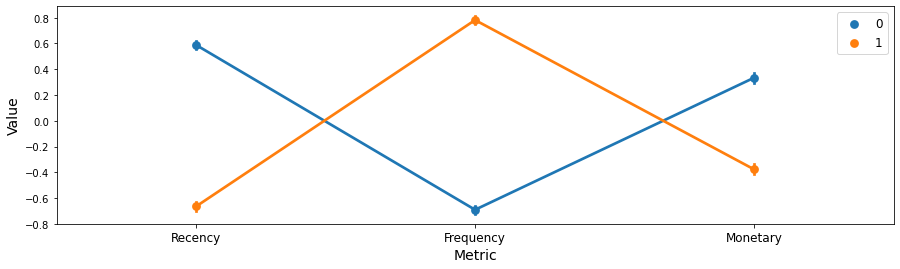

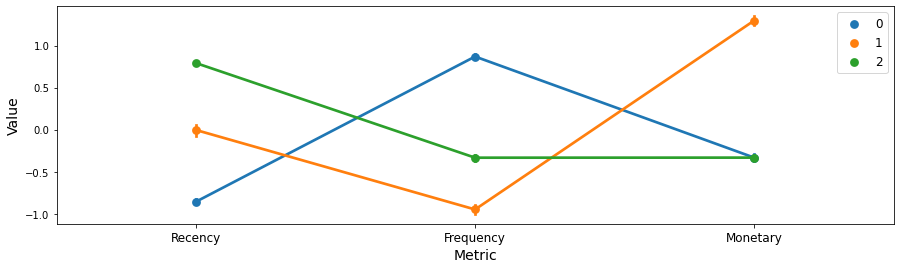

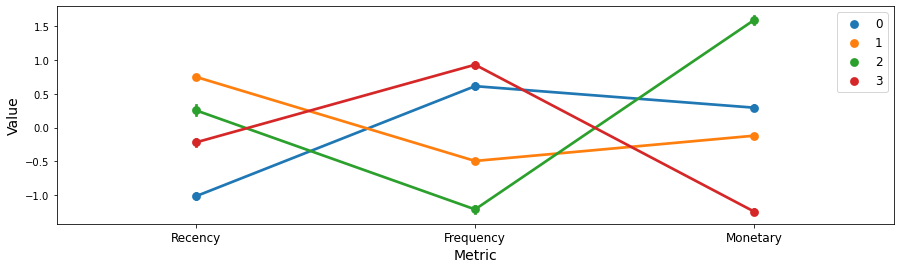

In [39]:
for k in range(2, 5):
    snake_plot(RFM_log_scaled.copy(), Clusters[k], RFM['CustomerID'])

### Clustering evaluation

- Silhouette visualizer

In [40]:
# Selected number of clusters
# 
n_clusters = 3

# Setup model
model = KMeans(n_clusters = n_clusters).fit( RFM_log_scaled ) 

# Fit model
model.fit( RFM_log_scaled )     

# Get Clustering-Results
RFM[ 'Cluster' ] = model.labels_

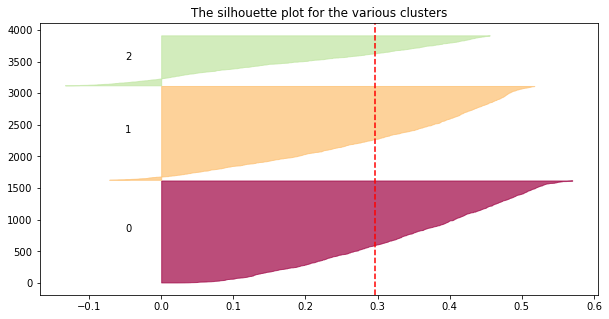

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

plt.figure( figsize = (10, 5))


Sil = silhouette_score(X      = RFM_log_scaled, 
                       labels = RFM[ 'Cluster' ])


sample_silhouette_values = silhouette_samples(X = RFM_log_scaled, labels = RFM['Cluster'])

y_lower = 10
for i in range( n_clusters ):
    ith_cluster_silhouette_values = sample_silhouette_values[ RFM['Cluster'] == i ]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
plt.axvline(x = Sil, color="red", linestyle="--")

# Set figure title
#
plt.title('The silhouette plot for the various clusters');

### Interpretation of the clusters formed using k-means
 

In [42]:
RFM.groupby(['Cluster']).agg({'Recency'   : 'mean',
                              'Frequency' : 'mean',
                              'Monetary'  :  ['mean', 'count']})

Recency   Frequency    Monetary      
               mean        mean        mean count
Cluster                                          
0        180.896402   38.213400   14.925448  1612
1         25.020229  186.376939   17.095064  1483
2         92.370886   20.618987  172.744278   790

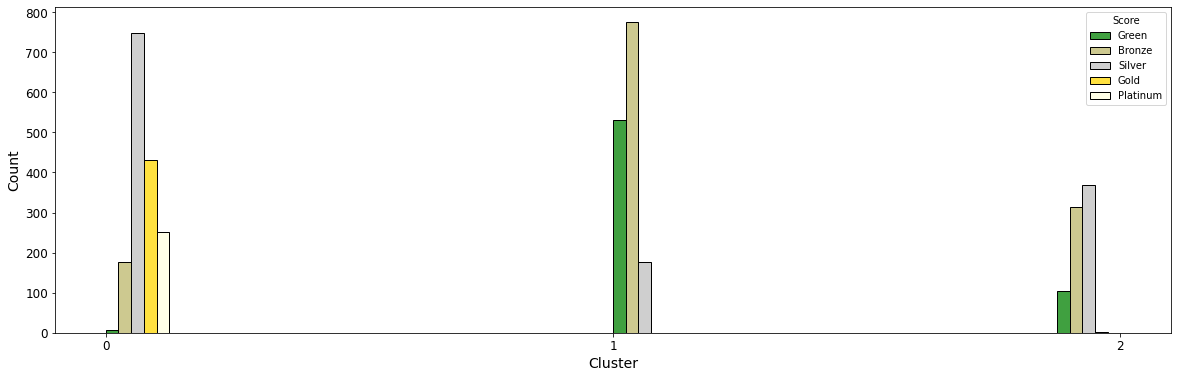

In [43]:
# Create an array with the colors you want to use
colors = ["green", "darkkhaki", "silver", "gold",  "lightyellow"]

# Set your custom color palette
sns.set_palette( sns.color_palette(colors) )



plt.figure( figsize = (20, 6) )
#
#
sns.histplot(data = RFM, x = 'Cluster', hue = 'Score', multiple="dodge", )
#
plt.xticks( np.arange(n_clusters), size = 12 );
plt.yticks( size = 12 );
#
plt.xlabel('Cluster', size = 14);
plt.ylabel('Count',   size = 14);

In [44]:
RFM.groupby(['Cluster', 'Score']).count()[ ['CustomerID'] ]

CustomerID
Cluster Score               
0       Bronze           176
        Gold             431
        Green              6
        Platinum         251
        Silver           748
1       Bronze           775
        Green            531
        Silver           177
2       Bronze           315
        Gold               1
        Green            105
        Silver           369

In [45]:
# - The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).
# - Customers in the second cluster can be interpreted as passerby customers as their last purchase is long ago (R=4),purchased very few (F=4) and spent little (M=4).Company has to come up with new strategies to make them permanent members.
# - The third cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=3), but used to purchase frequently and spent a lot.
# - The last cluster are very Loyal Customers and they also spent a lot.